In [1]:
"""
Goal:
- Explore a cleaned coffee quality dataset.
- Build and evaluate a logistic regression model to classify coffee
  species as Arabica (1) vs Robusta (0).
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)

df = pd.read_csv('../data/cleaned_data/FINAL_DATA.csv')

In [2]:
# 1. EDA

# 1.1 standardize the target column name ('species') 

target_col = None
for c in df.columns:
    if c.lower() == "species":
        target_col = c
        break

if target_col is None:
    for c in df.columns:
        if "species" in c.lower():
            target_col = c
            break

if target_col and target_col != "species":
    df = df.rename(columns={target_col: "species"})

y_str = df["species"].astype(str).str.strip().str.lower()
y_bin = y_str.map({"arabica": 1, "robusta": 0})

# 1.2 head, dtypes, and missingness

print("Head of data")
print(df.head(10))

cols_info = pd.DataFrame({
    "column": df.columns,
    "dtype": [str(df[c].dtype) for c in df.columns],
    "n_missing": df.isna().sum().values,
    "pct_missing": df.isna().mean().values,
}).sort_values(["pct_missing", "n_missing"], ascending=[False, False])

print("\nColumn info and missingness")
print(cols_info)


Head of data
  Country.of.Origin  Number.of.Bags  Bag.Weight  Harvest.Year Grading.Date  \
0          Thailand               1          10          2020   2024-10-29   
1          Thailand               1           8          2025   2025-07-08   
2          Thailand               1           7          2025   2025-10-02   
3          Thailand               1           8          2025   2025-08-26   
4          Thailand               1           7          2021   2025-10-02   
5          Thailand               1           8          2025   2025-07-08   
6          Thailand               1           7          2025   2025-10-02   
7          Thailand               1           8          2025   2025-10-02   
8          Ethiopia            1600       96000          2025   2025-04-08   
9            Taiwan               1           2          2025   2025-09-26   

  Processing.Method  Aroma  Flavor  Aftertaste  Acidity  ...  Clean.Cup  \
0        Washed/Wet   8.67    8.50        8.33     8.


Class balance (species)
         count  proportion
species                   
Arabica    311    0.773632
Robusta     91    0.226368


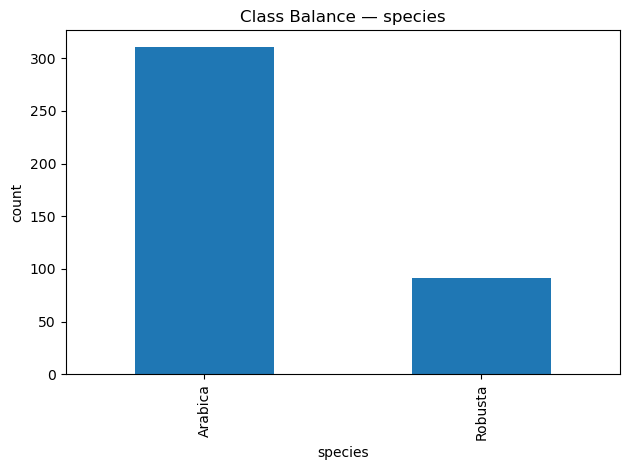


Numeric feature summary
                      count         mean           std       min       25%  \
Number.of.Bags        402.0  5204.034826  43753.953080     1.000     1.000   
Bag.Weight            402.0  1950.136816  13140.731760     1.000     2.000   
Harvest.Year          402.0  2024.537313      0.936833  2020.000  2024.000   
Aroma                 402.0     7.845025      0.309717     7.000     7.670   
Flavor                402.0     7.822786      0.316129     6.670     7.580   
Aftertaste            402.0     7.710299      0.301323     6.670     7.500   
Acidity               402.0     7.787512      0.303884     6.670     7.580   
Body                  402.0     7.724602      0.273285     6.580     7.580   
Balance               402.0     7.740871      0.296937     6.580     7.500   
Uniformity            402.0     9.965149      0.220585     8.000    10.000   
Clean.Cup             402.0     9.983433      0.155090     8.000    10.000   
Sweetness             402.0     9.52599

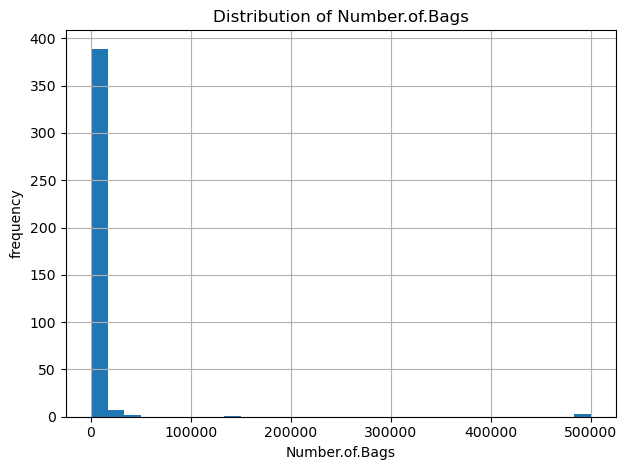

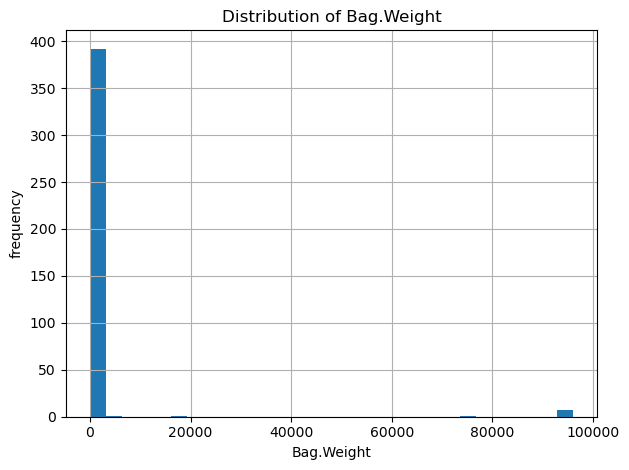

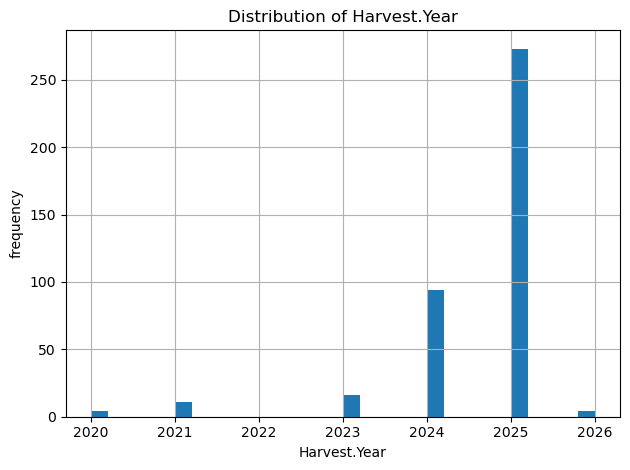

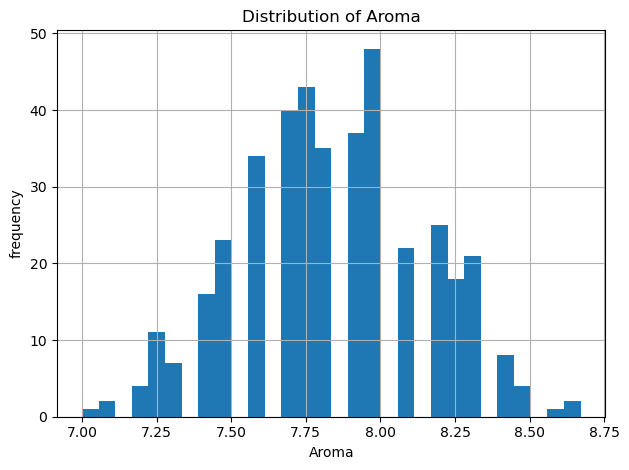

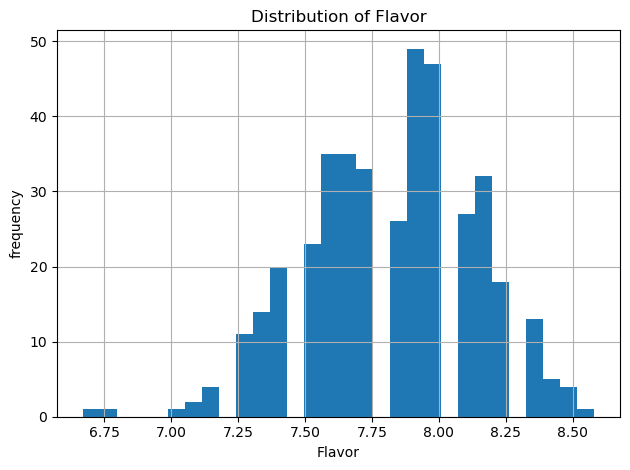

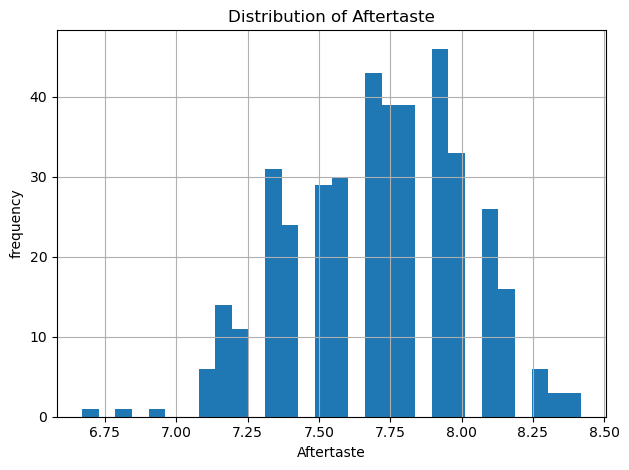

In [3]:
# 2. EDA: Target Distribution and Numeric Features

# 2.1 Class balance (species)

class_counts = df["species"].value_counts(dropna=False)
class_table = pd.DataFrame({
    "count": class_counts,
    "proportion": class_counts / len(df)
})
print("\nClass balance (species)")
print(class_table)

plt.figure()
class_counts.plot(kind="bar")
plt.title("Class Balance — species")
plt.xlabel("species")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# 2.2 numeric feature summary and histograms

# numeric columns = all columns with numeric dtypes
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

num_summary = df[numeric_cols].describe().T
print("\nNumeric feature summary")
print(num_summary)

# histograms for a subset of numeric variables
for col in numeric_cols[:6]:  # adjust slice
    plt.figure()
    df[col].dropna().hist(bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("frequency")
    plt.tight_layout()
    plt.show()


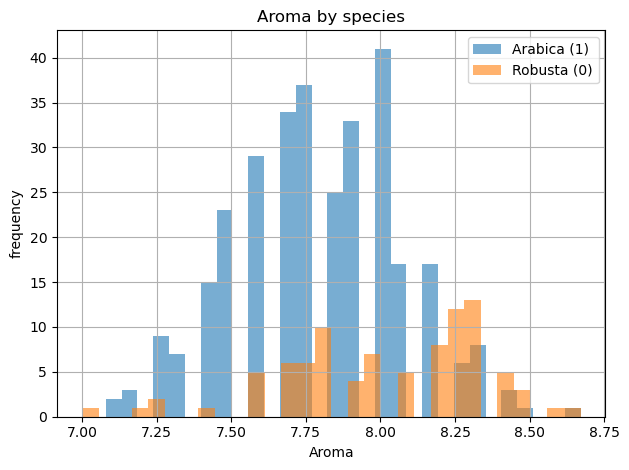

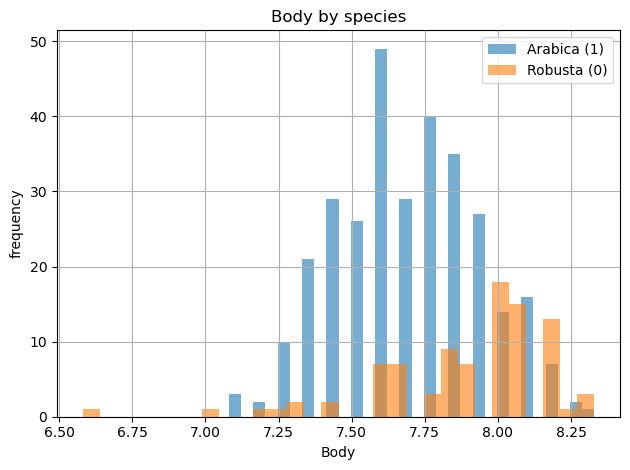

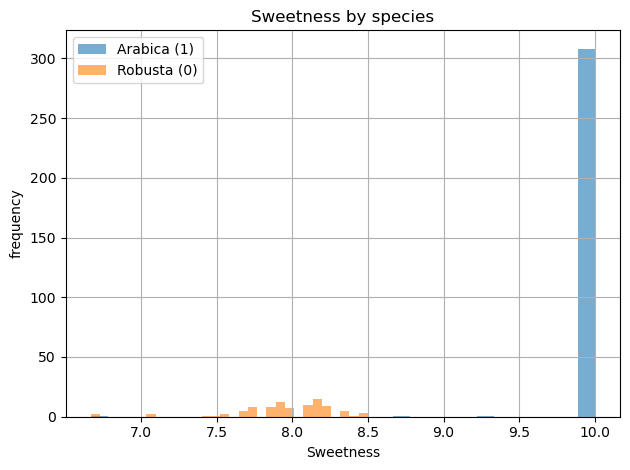

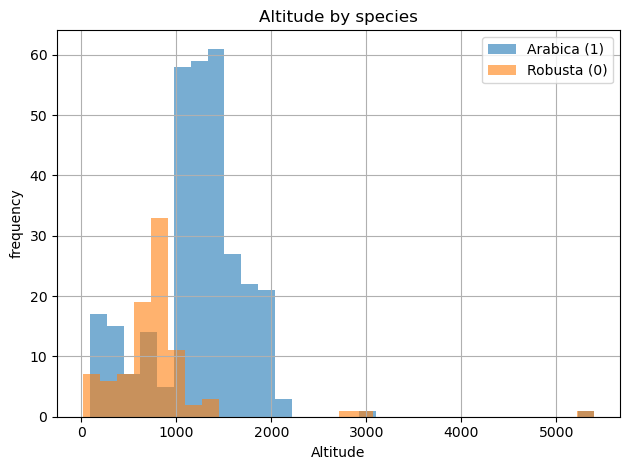


Numeric correlation matrix (first 5 rows)
                Number.of.Bags  Bag.Weight  Harvest.Year     Aroma    Flavor  \
Number.of.Bags        1.000000   -0.012538      0.058311  0.033318  0.041584   
Bag.Weight           -0.012538    1.000000      0.072155 -0.047321 -0.002703   
Harvest.Year          0.058311    0.072155      1.000000  0.074641  0.043602   
Aroma                 0.033318   -0.047321      0.074641  1.000000  0.880064   
Flavor                0.041584   -0.002703      0.043602  0.880064  1.000000   

                Aftertaste   Acidity      Body   Balance  Uniformity  \
Number.of.Bags    0.057772  0.070444  0.065274  0.054535    0.017512   
Bag.Weight       -0.001500  0.062016  0.073148  0.007430   -0.141980   
Harvest.Year      0.077700  0.119721  0.097754  0.092801    0.034486   
Aroma             0.848618  0.821987  0.799864  0.833026    0.073599   
Flavor            0.909066  0.892574  0.863890  0.881577    0.081398   

                Clean.Cup  Sweetness  Moist

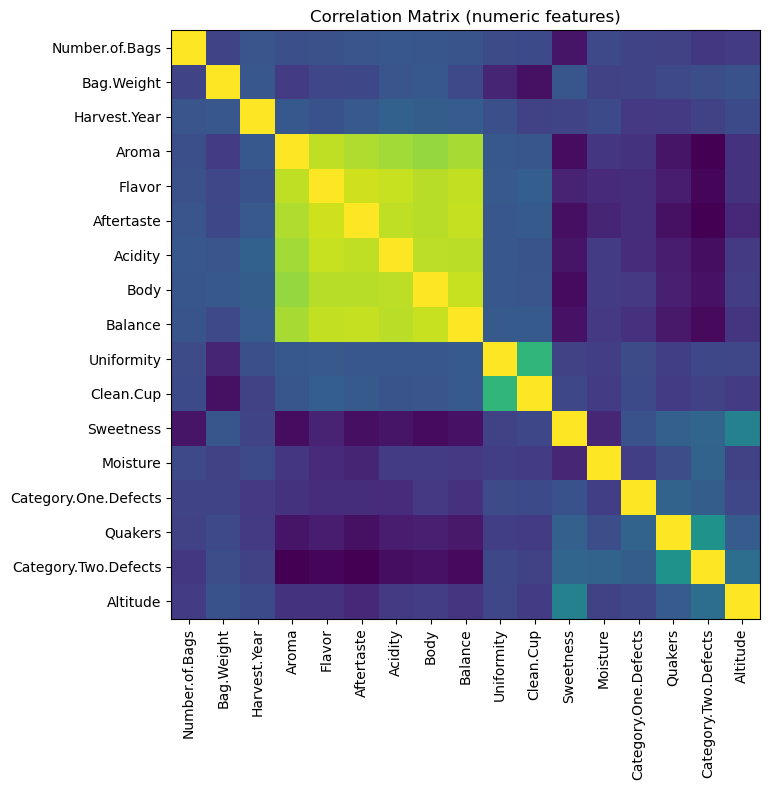

In [4]:
# 3. EDA: class conditioned distributions and correlation

# 3.1 helper func for class conditioned hist

def class_hist(feature, bins=30):
    plt.figure()
    df.loc[y_bin == 1, feature].dropna().hist(
        bins=bins, alpha=0.6, label="Arabica (1)"
    )
    df.loc[y_bin == 0, feature].dropna().hist(
        bins=bins, alpha=0.6, label="Robusta (0)"
    )
    plt.title(f"{feature} by species")
    plt.xlabel(feature)
    plt.ylabel("frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

# plot a few key predictors by class
for feature in ["Aroma", "Body", "Sweetness", "Altitude"]:
    if feature in df.columns and feature in numeric_cols:
        class_hist(feature)

# 3.2 correlation matrix for numeric features 

corr = df[numeric_cols].corr(method="pearson")
print("\nNumeric correlation matrix (first 5 rows)")
print(corr.head())

plt.figure(figsize=(10, 8))
plt.imshow(corr.values)
plt.xticks(ticks=np.arange(len(numeric_cols)), labels=numeric_cols, rotation=90)
plt.yticks(ticks=np.arange(len(numeric_cols)), labels=numeric_cols)
plt.title("Correlation Matrix (numeric features)")
plt.tight_layout()
plt.show()


In [5]:
# 4. EDA: categorical features and outliers

# 4.1 Categorical summary and conditional species proportions 

# categorical columns = object dtype (strings)
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
# remove target if it is object type
if "species" in cat_cols:
    cat_cols.remove("species")

# top cat per categorical column
tops = []
for c in cat_cols:
    vc = df[c].astype(str).str.strip().value_counts(dropna=False).head(5)
    tops.append(pd.DataFrame({
        "column": c,
        "category": vc.index,
        "count": vc.values
    }))

if tops:
    cat_top_table = pd.concat(tops, ignore_index=True)
    print("\nTop categories per categorical column")
    print(cat_top_table)

# conditional proportions of species within each low-cardinality categorical
def cond_prop(col):
    # crosstab with row wise proportions
    return pd.crosstab(
        df[col].astype(str),
        df["species"].astype(str),
        normalize="index"
    )

cond_tables = {}
for c in cat_cols:
    if df[c].nunique(dropna=True) <= 12:
        cond_tables[c] = cond_prop(c)

if cond_tables:
    first_cat = list(cond_tables.keys())[0]
    print(f"\nConditional species proportions for '{first_cat}'")
    print(cond_tables[first_cat])

# 4.2 outlier rates (IQR method) for numeric features

out_rows = []
for c in numeric_cols:
    s = df[c].dropna().values
    if s.size == 0:
        continue
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    rate = float(((s < lower) | (s > upper)).mean())
    out_rows.append({
        "feature": c,
        "iqr_outlier_rate": rate,
        "q1": q1,
        "q3": q3,
        "lower": lower,
        "upper": upper,
    })

outlier_table = pd.DataFrame(out_rows).sort_values(
    "iqr_outlier_rate", ascending=False
)
print("\nOutlier rates (IQR method)")
print(outlier_table)



Top categories per categorical column
               column      category  count
0   Country.of.Origin        Taiwan    106
1   Country.of.Origin       Vietnam     89
2   Country.of.Origin      Thailand     61
3   Country.of.Origin     Indonesia     31
4   Country.of.Origin      Colombia     24
5        Grading.Date    2025-09-26     51
6        Grading.Date    2024-10-29     39
7        Grading.Date    2025-07-09     32
8        Grading.Date    2025-08-26     20
9        Grading.Date    2024-12-27     19
10  Processing.Method   Natural/Dry    173
11  Processing.Method    Washed/Wet    162
12  Processing.Method         Honey     60
13  Processing.Method  Fermentation      3
14  Processing.Method           nan      2
15              Color         Green    257
16              Color  Yellow-Green     41
17              Color    Blue-Green     41
18              Color        Yellow     34
19              Color         Brown     19
20         Expiration    2026-09-26     51
21         Expi


Classification report (threshold 0.5)
              precision    recall  f1-score   support

           0      1.000     0.957     0.978        23
           1      0.987     1.000     0.994        78

    accuracy                          0.990       101
   macro avg      0.994     0.978     0.986       101
weighted avg      0.990     0.990     0.990       101

ROC-AUC: 0.998
PR-AUC (Average Precision): 1.0

Confusion matrix
[[22  1]
 [ 0 78]]


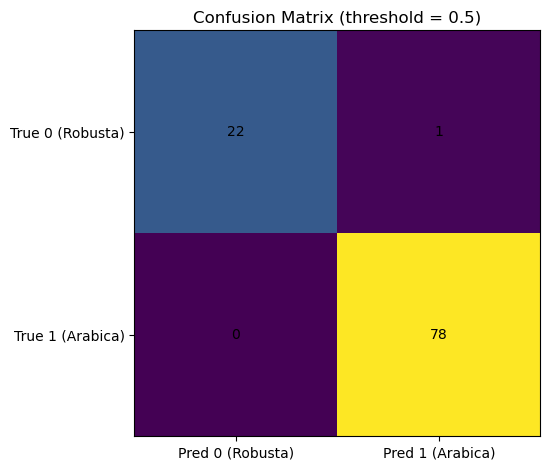

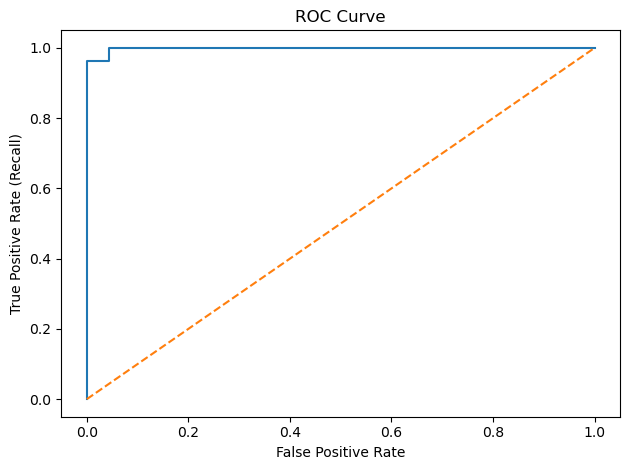

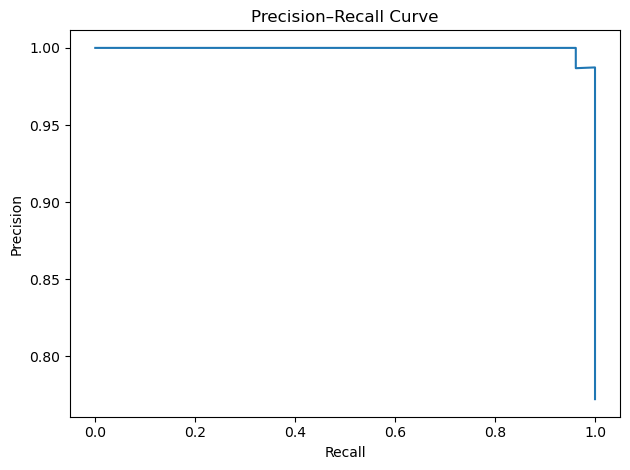


Top 15 features by absolute coefficient
                                feature      coef
11                       num__Sweetness  2.927490
41       cat__Country.of.Origin_Vietnam -0.704020
16                        num__Altitude  0.688349
30         cat__Country.of.Origin_Kenya  0.656730
66         cat__Grading.Date_2025-03-25  0.647682
150          cat__Expiration_2026-03-25  0.647682
26         cat__Country.of.Origin_India -0.531108
37        cat__Country.of.Origin_Taiwan  0.453031
12                        num__Moisture -0.425875
6                          num__Acidity -0.425830
127          cat__Expiration_2025-11-07 -0.348475
43         cat__Grading.Date_2024-11-07 -0.348475
117  cat__Processing.Method_Natural/Dry -0.338662
118   cat__Processing.Method_Washed/Wet  0.322375
121                    cat__Color_Green  0.255574


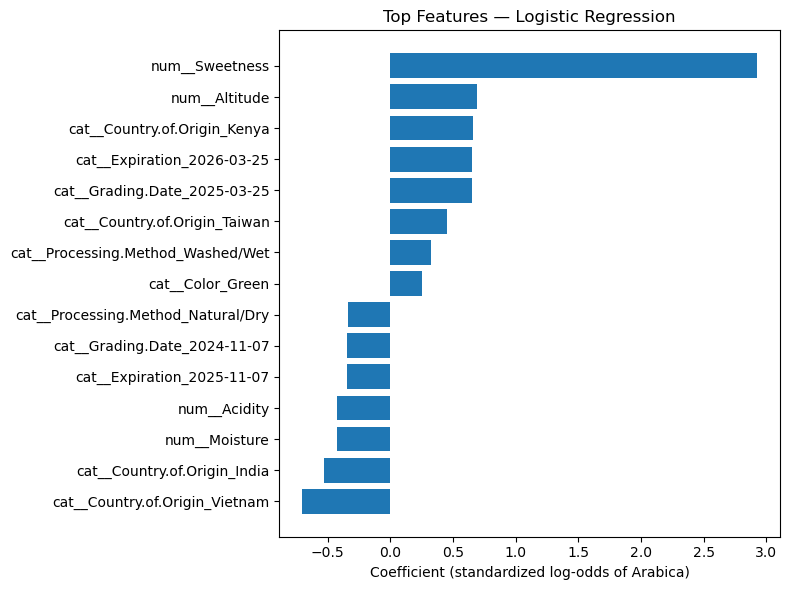

In [6]:
# 5. Logistic regression modeling

# The goal is to predict species (Arabica vs Robusta) from quality and
# production features using a regularized logistic regression model

# 5.1 Define features (X) and target (y)

X = df.drop(columns=["species"]).copy()
y = y_bin.copy()

# drop any rows where target is missing
valid_rows = y.notna()
X = X.loc[valid_rows].reset_index(drop=True)
y = y.loc[valid_rows].astype(int).reset_index(drop=True)

# 5.2 train test split (75% train, 25% test, stratified)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y,
)

# 5.3 column lists for preprocessing

numeric_cols_model = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols_model = X.select_dtypes(include=["object"]).columns.tolist()

# 5.4 preprocessing pipelines

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_cols_model),
        ("cat", categorical_pipe, categorical_cols_model),
    ],
    remainder="drop",
)

# 5.5 logistic regression model (with class weights)

log_reg = LogisticRegression(
    penalty="l2",
    class_weight="balanced",
    max_iter=1000,
    solver="lbfgs",
)

# 5.6 full pipeline: preprocessing + model

clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", log_reg),
])

# 5.7 fitting the model

clf.fit(X_train, y_train)

# 5.8 evaluation on test set

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]  # P(species = Arabica)

print("\nClassification report (threshold 0.5)")
print(classification_report(y_test, y_pred, digits=3))

print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))
print("PR-AUC (Average Precision):", round(average_precision_score(y_test, y_prob), 3))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix")
print(cm)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (threshold = 0.5)")
plt.xticks([0, 1], ["Pred 0 (Robusta)", "Pred 1 (Arabica)"])
plt.yticks([0, 1], ["True 0 (Robusta)", "True 1 (Arabica)"])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()

# 5.9 roc and precision recall curves

fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.tight_layout()
plt.show()

prec, rec, thresholds_pr = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.tight_layout()
plt.show()

# 5.10 top model coefficients (simple version)

# feature names after preprocessing
feature_names = clf.named_steps["prep"].get_feature_names_out()
# coefficients: first row corresponds to class 1 (Arabica)
coefs = clf.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

print("\nTop 15 features by absolute coefficient")
print(coef_df.head(15)[["feature", "coef"]])

# bar plot of top coefficients
topN = 15
top_df = coef_df.head(topN).sort_values("coef")
plt.figure(figsize=(8, 6))
plt.barh(top_df["feature"], top_df["coef"])
plt.xlabel("Coefficient (standardized log-odds of Arabica)")
plt.title("Top Features — Logistic Regression")
plt.tight_layout()
plt.show()


## Interpretation

The logistic regression model performed exceptionally well at classifying coffee species as Arabica versus Robusta, indicating that coffee quality and production attributes are highly informative for species differentiation. Using a full preprocessing pipeline with standardization for numeric features and one-hot encoding for categorical features, along with a stratified train–test split, the model achieved an overall test accuracy of 99%, with a confusion matrix showing only 1 misclassification out of 101 test observations. Performance metrics further support this result, with a ROC-AUC of 0.998 and a PR-AUC of 1.0, demonstrating excellent class separability even under class imbalance. Examination of the standardized coefficients suggests that sweetness is the strongest positive predictor of Arabica classification, followed by altitude and certain country-of-origin and processing method indicators, while lower sweetness, higher moisture, and specific origins are more associated with Robusta. Overall, these results show that a regularized logistic regression model provides both strong predictive performance and clear interpretability for distinguishing between coffee species in this dataset.